In [1]:
import os, sys

sys.path.append('..' + os.sep + 'preprocess2')

from common import*

from sklearn.neighbors import KDTree
import matplotlib.pyplot as plt

FilterNeurokitWarnings()

In [2]:
BEG_TRAIN = '..' + os.sep + 'preprocess2' + os.sep + 'AgeGroups' + os.sep + '0' + os.sep
BEG_TEST = '..' + os.sep + 'data' + os.sep + 'TestData' + os.sep

dfAgeSex = pd.read_csv(BEG_TEST + 'attributes.csv')
with h5py.File(BEG_TEST + 'ecg_tracings.hdf5') as f:
    M = np.array(f['tracings'])
dfLabels = pd.read_csv(BEG_TEST + 'annotations' + os.sep + 'gold_standard.csv')

def GetTestAge(i):
    return dfAgeSex.values[i][0]

testLabels = dfLabels.values
# deixar as labels na mesma ordem do treino
testLabels[:,4], testLabels[:,5] = testLabels[:,5], testLabels[:,4].copy()

def GetTargetAgeGroup(targetAge):
    targetAge = min(max(MIN_AGE, targetAge), MAX_AGE)
    targetAgeGroup = targetAge - MIN_AGE
    AGE_OFF = 5
    div = targetAgeGroup // AGE_OFF
    start = MIN_AGE + div * AGE_OFF
    end = start + AGE_OFF - 1
    targetAgeGroup = str(start) + '-' + str(end)
    return targetAgeGroup

def GetModel(targetAgeGroup):
    start = BEG_TRAIN + str(targetAgeGroup) + os.sep
    mappings = np.load(start + 'mappings.npy')
    ecgs = np.load(start + 'ecgs.npy')
    ondas = np.load(start + 'ondas.npy')
    labels = np.load(start + 'labels.npy')
    tree = KDTree(ondas)
    return tree, ecgs, labels, mappings
    
def GetECGAndLabelsInNewAgeGroup(ecg, model):
    '''
    retorna o ECG mais próximo no espaço de features na nova idade,
    e as labels dele. Essa função faz tudo do 0 (lê os dados, constrói o modelo (KDTree)),
    então se o mesmo modelo for usado várias vezes, faz sentido parametrizar isso.
    '''
    
    w = ecg - ecg.mean()
    try:
        d = nk.ecg_delineate(w, sampling_rate=SAMPLE_RATE)[1]
    except:
        raise Exception('Neurokit não conseguiu delinear esse ECG')
    
    starts = d['ECG_P_Onsets']
    coeffs = []
    for j in range(len(starts) - 1):
        cur = starts[j]
        nxt = starts[j + 1]
        if math.isnan(cur) or math.isnan(nxt):
            #print('Neurokit retornou nan')
            continue
            
        period = w[cur:nxt]
        if not len(period):
            print('Neurokit retornou período vazio')
            break
            
        coeffs.append(GetCoeff(period))
    
    if not len(coeffs):
        raise Exception('Neurokit não conseguiu encontrar batimentos nesse ECG')

    tree, ecgs, labels, mappings = model
        
    dist, ind = tree.query(coeffs)
    gIdx = dist.argmin()
    idxClosestOnda = ind[gIdx][0]
    ecgOrgRow = mappings[idxClosestOnda]
    ecgClosest = ecgs[ecgOrgRow]
    labelsEcgClosest = labels[ecgOrgRow]
    
    return ecgClosest, labelsEcgClosest

In [3]:
def get_group_results(age_pair, age_groups):
    
    accuracy = []
    sample = dfAgeSex[(dfAgeSex['age'] >= age_pair[0]) & (dfAgeSex['age'] <= age_pair[1])].copy()
    
    for age_group in age_groups:
        
        targetAgeGroup = GetTargetAgeGroup(age_group[0])
        model = GetModel(targetAgeGroup)
        matched = []
        
        for pessoa in sample.index:
            
            ecg = M[pessoa, :, ELETRODO_IDX]
            age = GetTestAge(pessoa)
            
            def get():
                try:
                    labelsEcgClosest = GetECGAndLabelsInNewAgeGroup(ecg, model)[1]
                    return labelsEcgClosest
                except:
                    print('Erro no ECG', pessoa)
                    return None
                
            labelsEcgClosest = get()
            if labelsEcgClosest is not None:
                pessoaLabels = testLabels[pessoa]
                cmp = pessoaLabels == labelsEcgClosest
                matched.append(cmp)
                
        matched = np.array(matched, dtype=int)
        results = (matched.sum(axis=1)==6).sum()
        N = len(matched)
        if not N:
            acc = 1
        else:
            acc = results / N
        accuracy.append(acc)
        
    return np.array(accuracy)

In [4]:
def plot_accuracy(age_groups, target_age, results):
    plt.figure(figsize=(12,8))
    plt.plot(np.array(age_groups)[:,0], results)
    plt.xlabel('Age group')
    plt.ylabel('Accuracy score')
    plt.title('Accuracy score X Age group - (' + str(target_age[0]) + ',' + str(target_age[1]) + ')')
    plt.xticks(ticks=np.array(age_groups)[:,0],labels=[str(i) for i in age_groups])
    plt.show()

In [5]:
age_groups = [(17,21)
             ,(22,26)
             ,(27,31)
             ,(32,36)
             ,(37,41)
             ,(42,46)
             ,(47,51)
             ,(52,56)
             ,(57,61)
             ,(62,66)
             ,(67,71)
             ,(72,76)
             ,(77,81)
             ,(82,86)
             ,(87,91)]

In [6]:
accuracy = get_group_results((17,21), age_groups)

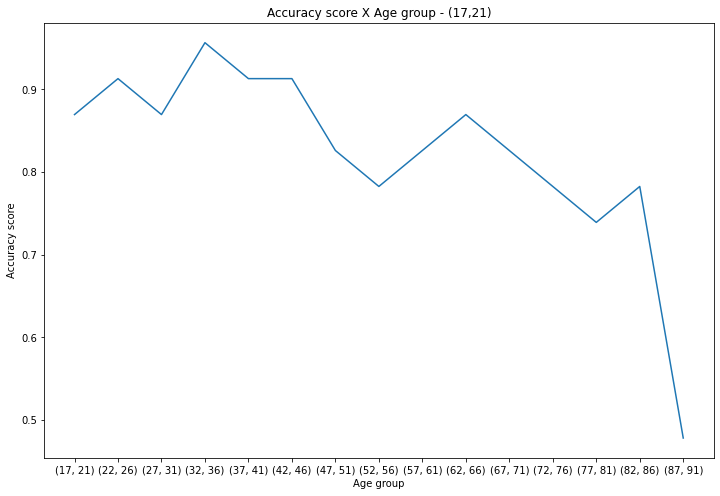

In [7]:
plot_accuracy(age_groups, (17,21), accuracy)

In [8]:
accuracy2 = get_group_results((22,26), age_groups)

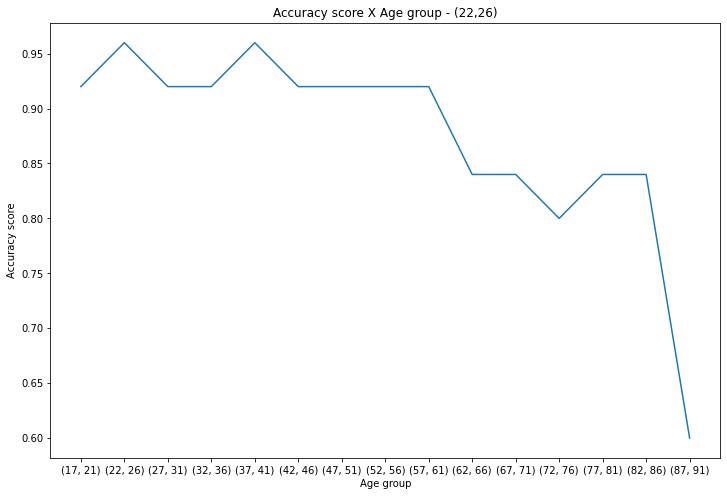

In [9]:
plot_accuracy(age_groups, (22,26), accuracy2)

In [10]:
accuracy3 = get_group_results((27,31), age_groups)

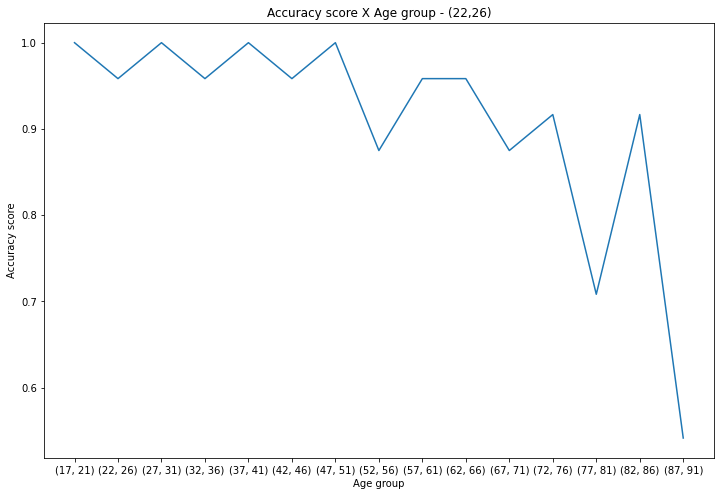

In [11]:
plot_accuracy(age_groups, (22,26), accuracy3)

In [12]:
accuracy4 = get_group_results((32,36), age_groups)

Erro no ECG 441
Erro no ECG 441
Erro no ECG 441
Erro no ECG 441
Erro no ECG 441
Erro no ECG 441
Erro no ECG 441
Erro no ECG 441
Erro no ECG 441
Erro no ECG 441
Erro no ECG 441
Erro no ECG 441
Erro no ECG 441
Erro no ECG 441
Erro no ECG 441


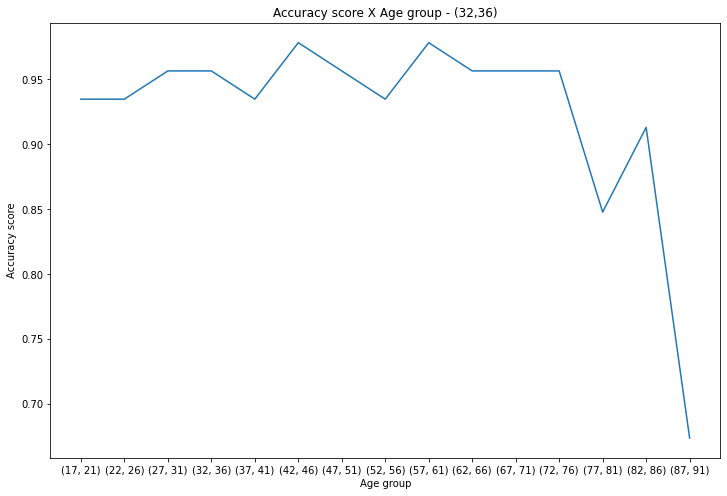

In [13]:
plot_accuracy(age_groups, (32,36), accuracy4)

In [14]:
accuracy5 = get_group_results((37,41), age_groups)

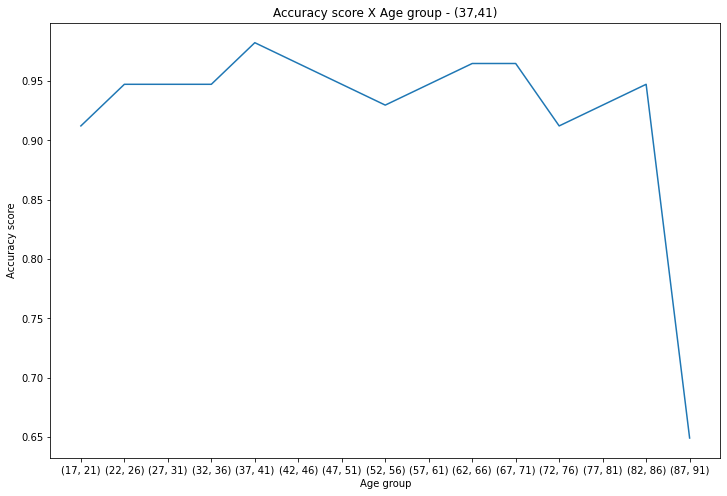

In [15]:
plot_accuracy(age_groups, (37,41), accuracy5)

In [16]:
accuracy6 = get_group_results((42,46), age_groups)

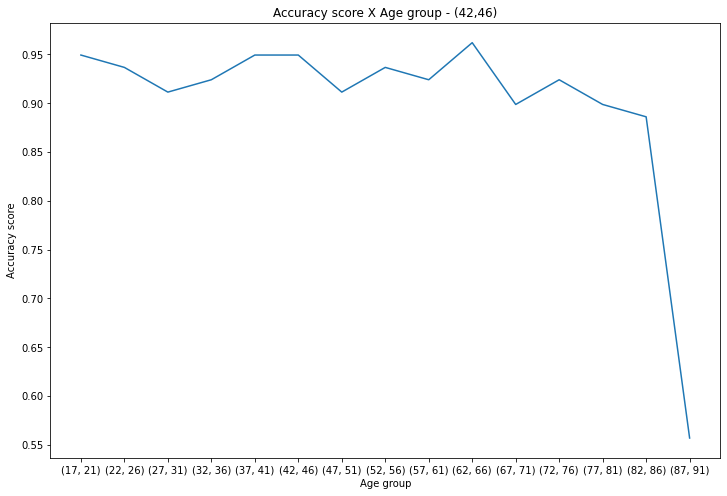

In [17]:
plot_accuracy(age_groups, (42,46), accuracy6)

In [18]:
accuracy7 = get_group_results((47,51), age_groups)

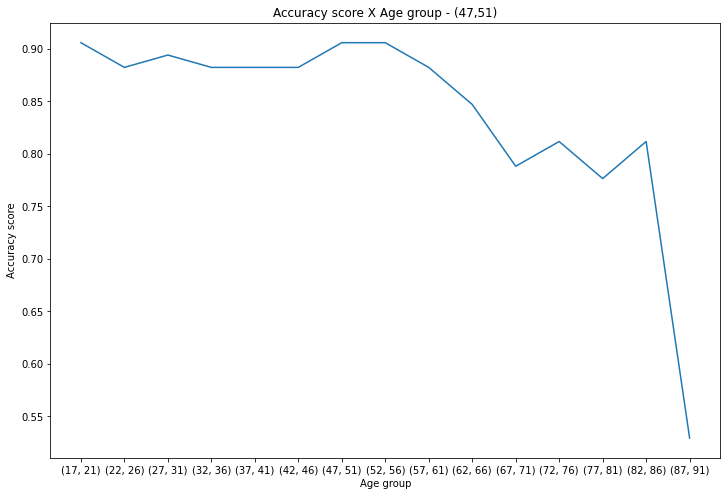

In [19]:
plot_accuracy(age_groups, (47,51), accuracy7)

In [20]:
accuracy8 = get_group_results((52,56), age_groups)

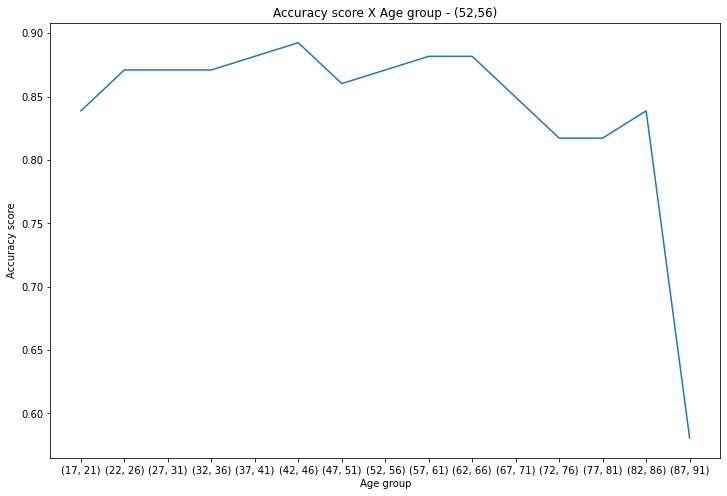

In [21]:
plot_accuracy(age_groups, (52,56), accuracy8)

In [22]:
accuracy9 = get_group_results((57,61), age_groups)

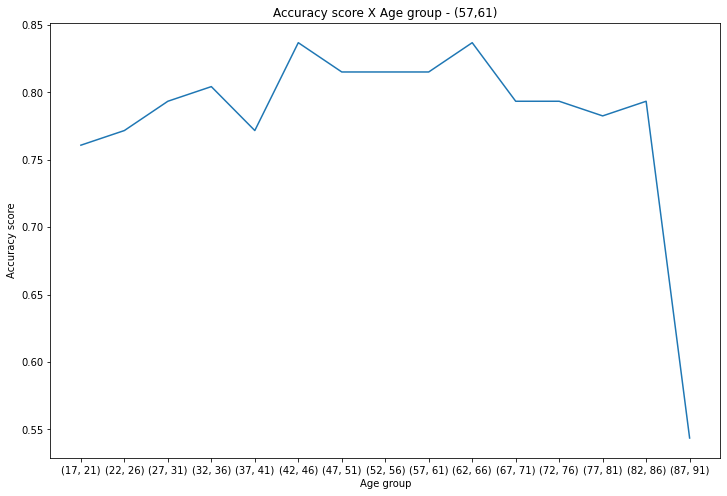

In [23]:
plot_accuracy(age_groups, (57,61), accuracy9)

In [24]:
accuracy10 = get_group_results((62,66), age_groups)

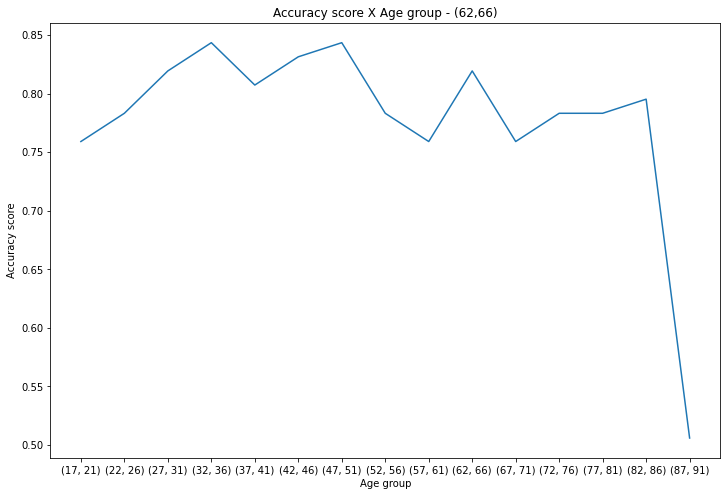

In [25]:
plot_accuracy(age_groups, (62,66), accuracy10)

In [26]:
accuracy10_1 = get_group_results((67,71), age_groups)

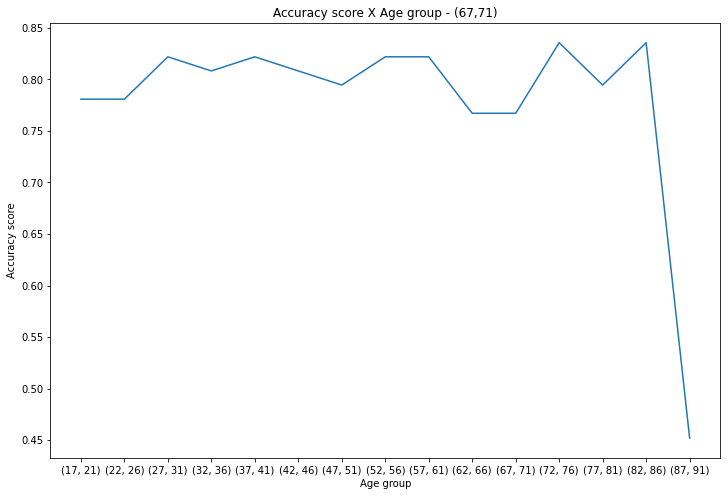

In [27]:
plot_accuracy(age_groups, (67,71), accuracy10_1)

In [28]:
accuracy10_2 = get_group_results((72,76), age_groups)

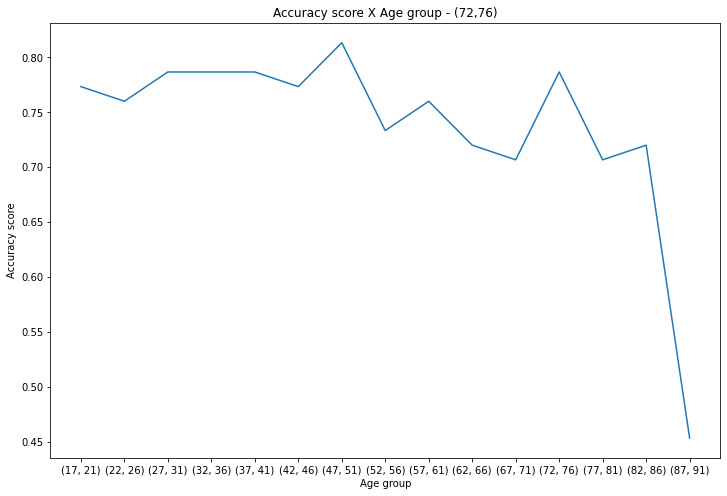

In [29]:
plot_accuracy(age_groups, (72,76), accuracy10_2)

In [30]:
accuracy11 = get_group_results((77,81), age_groups)

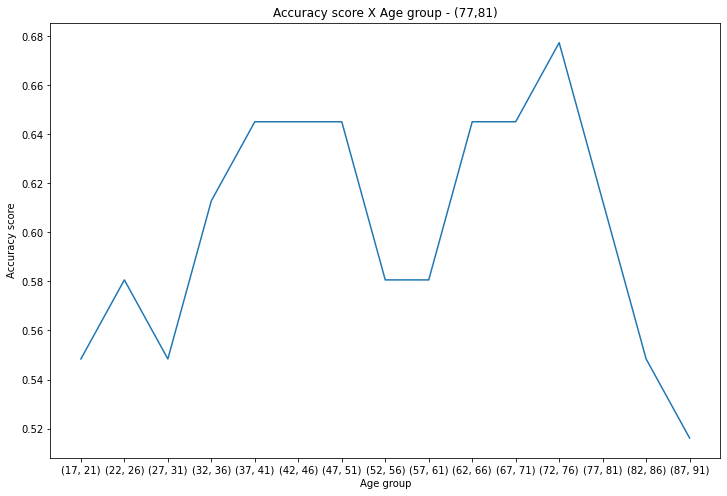

In [31]:
plot_accuracy(age_groups, (77,81), accuracy11)

In [32]:
accuracy12 = get_group_results((82,86), age_groups)

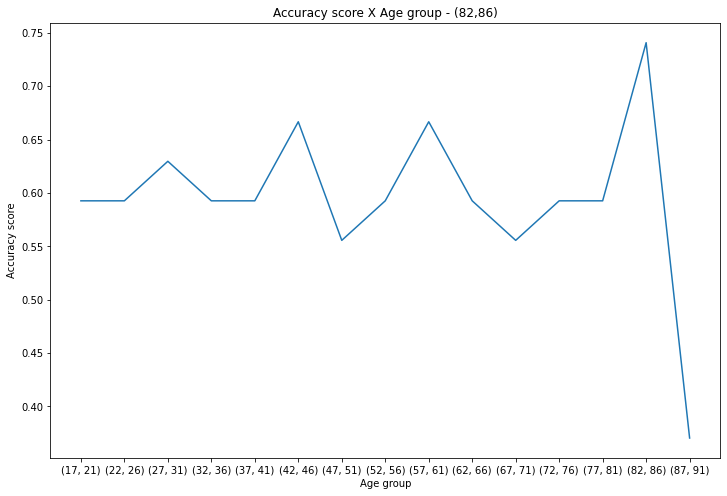

In [33]:
plot_accuracy(age_groups, (82,86), accuracy12)

In [34]:
accuracy13 = get_group_results((87,91), age_groups)

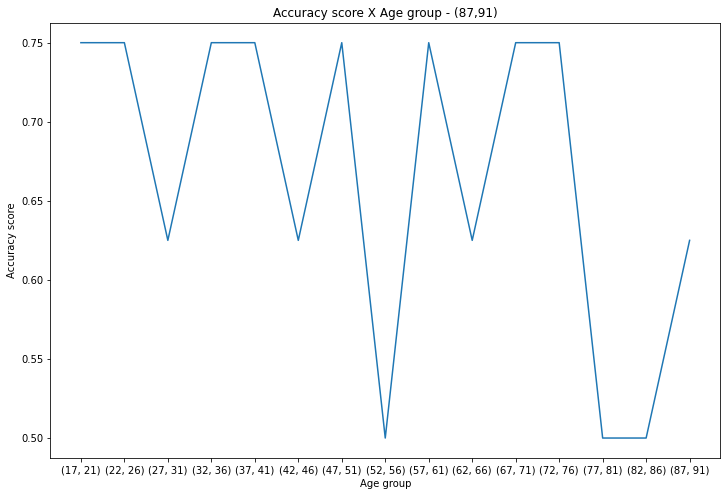

In [35]:
plot_accuracy(age_groups, (87,91), accuracy13)

In [37]:
import seaborn as sns

In [38]:
df = pd.DataFrame(np.array([accuracy
                           ,accuracy2, accuracy3
                           ,accuracy4, accuracy5
                           ,accuracy6, accuracy7
                           ,accuracy8, accuracy9
                           ,accuracy10, accuracy10_1
                           ,accuracy10_2, accuracy11
                           ,accuracy12,accuracy13]), columns=age_groups, index=age_groups)

In [39]:
df

,"(17, 21)","(22, 26)","(27, 31)","(32, 36)","(37, 41)","(42, 46)","(47, 51)","(52, 56)","(57, 61)","(62, 66)","(67, 71)","(72, 76)","(77, 81)","(82, 86)","(87, 91)"
"(17, 21)",0.869565,0.913043,0.869565,0.956522,0.913043,0.913043,0.826087,0.782609,0.826087,0.869565,0.826087,0.782609,0.739130,0.782609,0.478261
"(22, 26)",0.920000,0.960000,0.920000,0.920000,0.960000,0.920000,0.920000,0.920000,0.920000,0.840000,0.840000,0.800000,0.840000,0.840000,0.600000
"(27, 31)",1.000000,0.958333,1.000000,0.958333,1.000000,0.958333,1.000000,0.875000,0.958333,0.958333,0.875000,0.916667,0.708333,0.916667,0.541667
"(32, 36)",0.934783,0.934783,0.956522,0.956522,0.934783,0.978261,0.956522,0.934783,0.978261,0.956522,0.956522,0.956522,0.847826,0.913043,0.673913
"(37, 41)",0.912281,0.947368,0.947368,0.947368,0.982456,0.964912,0.947368,0.929825,0.947368,0.964912,0.964912,0.912281,0.929825,0.947368,0.649123
"(42, 46)",0.949367,0.936709,0.911392,0.924051,0.949367,0.949367,0.911392,0.936709,0.924051,0.962025,0.898734,0.924051,0.898734,0.886076,0.556962
"(47, 51)",0.905882,0.882353,0.894118,0.882353,0.882353,0.882353,0.905882,0.905882,0.882353,0.847059,0.788235,0.811765,0.776471,0.811765,0.529412
"(52, 56)",0.838710,0.870968,0.870968,0.870968,0.881720,0.892473,0.860215,0.870968,0.881720,0.881720,0.849462,0.817204,0.817204,0.838710,0.580645
"(57, 61)",0.760870,0.771739,0.793478,0.804348,0.771739,0.836957,0.815217,0.815217,0.815217,0.836957,0.793478,0.793478,0.782609,0.793478,0.543478
"(62, 66)",0.759036,0.783133,0.819277,0.843373,0.807229,0.831325,0.843373,0.783133,0.759036,0.819277,0.759036,0.783133,0.783133,0.795181,0.506024


<AxesSubplot:>

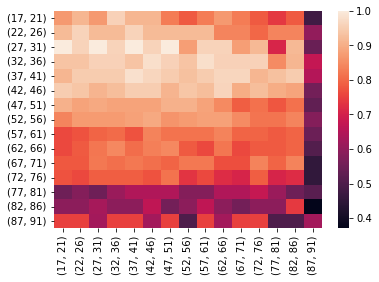

In [40]:
sns.heatmap(df)